# **Image preprocessing**
**Image processing** is divided into analogue image processing and digital image processing.

**Digital image processing** is the use of computer algorithms to perform image processing on digital images. It allows a much wider range of algorithms to be applied to the input data - the aim of digital image processing is to improve the image data (features) by suppressing unwanted distortions and/or enhancement of some important image features so that our **AI models** can benefit from this improved data to work on.


# **Installing necessary dependencies**


In [1]:
# OpenCV
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python



     |████████████████████████████████| 26.6MB 1.2MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


# **Python Code using Opencv and matplotlib libraries **

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import drive

# Accessing My Google Drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# defining global variable path
# Location of my dataset on My Google Drive
image_path = "drive/My Drive/SensorTower/dataset"


def loadImages(path):
    '''Put files into lists and return them as one list with all images 
     in the folder'''
    image_files = sorted([os.path.join(path, 'train', file)
                          for file in os.listdir(path + "/train")
                          if file.endswith('.png') or file.endswith('.jpg') or file.endswith('jpeg')])
    return image_files



# **Displaying Images**

In [0]:
# Display two images
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

# Display one image
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.show()



# Preprocessing the images:
* Read image
* Resize image 
* Remove noise(Denoise)
* Segmentation
* Morphology(smoothing edges)

In [0]:
# Preprocessing
def processing(data):
    
    # Reading 3 images to work
    img = [cv2.imread(i, cv2.IMREAD_UNCHANGED) for i in data[:3]]
    try:
        print('Original size',img[0].shape)
    except AttributeError:
        print("shape not found")
   
    # --------------------------------
    # setting dim of the resize
    height = 64
    width = 64
    dim = (width, height)
    res_img = []
    for i in range(len(img)):
        res = cv2.resize(img[i], dim, interpolation=cv2.INTER_LINEAR)
        res_img.append(res)

    
        
    # Checcking the size
    try:
        print('RESIZED', res_img[1].shape)
    except AttributeError:
        print("shape not found")
    
    
    # Visualizing one of the images in the array
    original = res_img[1]
    display_one(original)
    # ----------------------------------
    # Remove noise
    # Using Gaussian Blur
    no_noise = []
    for i in range(len(res_img)):
        blur = cv2.GaussianBlur(res_img[i], (5, 5), 0)
        no_noise.append(blur)


    image = no_noise[1]
    display(original, image, 'Original', 'Blured')
    #---------------------------------
    # Segmentation
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Displaying segmented images
    display(original, thresh, 'Original', 'Segmented')
    # Further noise removal (Morphology)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    #Displaying segmented back ground
    display(original, sure_bg, 'Original', 'Segmented Background')

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0

    markers = cv2.watershed(image, markers)
    image[markers == -1] = [255, 0, 0]

    # Displaying markers on the image
    display(original, markers, 'Original', 'Marked')

# Main Function the heart of the program

List of files the first 3 in the folder:
 ['drive/My Drive/SensorTower/dataset/train/1.top-1760x770.jpg', 'drive/My Drive/SensorTower/dataset/train/10.maxresdefault.jpg', 'drive/My Drive/SensorTower/dataset/train/11.33601934-jamsa-finland-august-28-2014-volvo-fh16-700-timber-truck-with-a-full-load-of-birch-the-export-of-fin.jpg']
--------------------------------
Original size (770, 1760, 3)
RESIZED (220, 220, 3)


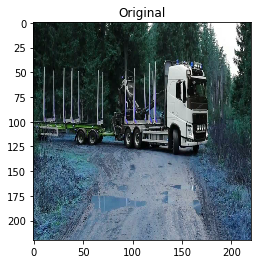

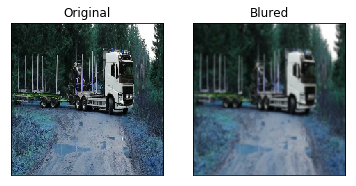

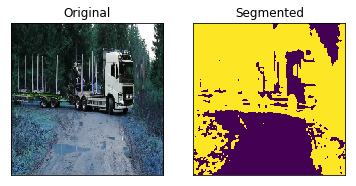

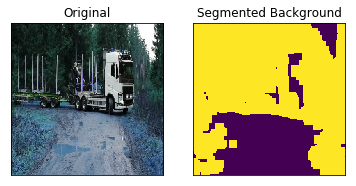

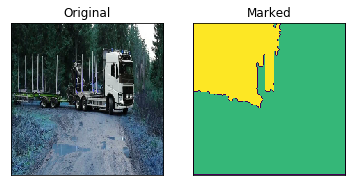

In [8]:
def main():
    # calling global variable
    global image_path
    '''The var Dataset is a list with all images in the folder '''
    dataset = loadImages(image_path)
    
    print("List of files the first 3 in the folder:\n",dataset[:3])
    print("--------------------------------")
    
    # sending all the images to pre-processing
    processing(dataset)
   

  
main()